# Transfer Learning

... following https://keras.io/guides/transfer_learning/

In [1]:
import tensorflow_datasets as tfds

tfds.disable_progress_bar()

train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    # Reserve 10% for validation and 10% for test
    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
    as_supervised=True,  # Include labels
)

Shuffling and writing examples to /Users/natalie/tensorflow_datasets/cats_vs_dogs/4.0.0.incomplete7EY09E/cats_vs_dogs-train.tfrecord
Dataset cats_vs_dogs downloaded and prepared to /Users/natalie/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


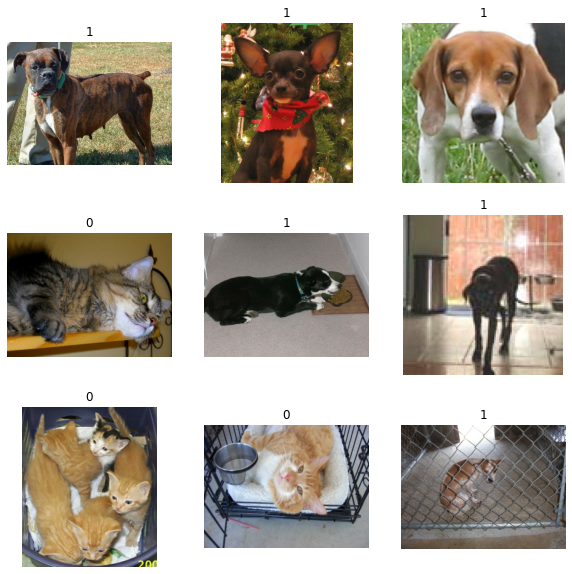

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

In [4]:
import tensorflow as tf
size = (150, 150)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))

batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

In [5]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

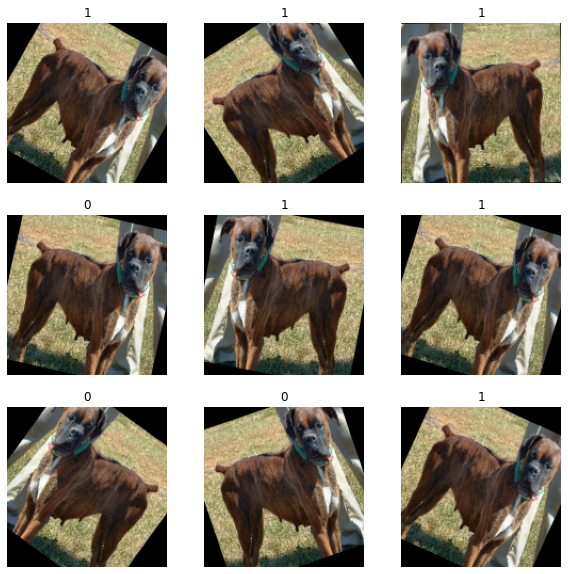

In [6]:
import numpy as np

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [7]:
base_model = keras.applications.Xception(
    weights="imagenet",
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)

# Pre-trained Xception weights requires that input be normalized
# from (0, 255) to a range (-1., +1.), the normalization layer
# does the following, outputs = (inputs - mean) / sqrt(var)
norm_layer = keras.layers.experimental.preprocessing.Normalization()
mean = np.array([127.5] * 3)
var = mean ** 2
# Scale inputs to [-1, +1]
x = norm_layer(x)
norm_layer.set_weights([mean, var])

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

83689472/83683744 [==============================] - 86s 1us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 150, 150, 3)       0         
_________________________________________________________________
normalization (Normalization (None, 150, 150, 3)       7         
_________________________________________________________________
xception (Model)             (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_____________________________________________________________

In [8]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 20
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/20
291/291 [==============================] - 519s 2s/step - loss: 0.1849 - binary_accuracy: 0.9154 - val_loss: 0.0897 - val_binary_accuracy: 0.9686
Epoch 2/20
291/291 [==============================] - 445s 2s/step - loss: 0.1374 - binary_accuracy: 0.9375 - val_loss: 0.0922 - val_binary_accuracy: 0.9695
Epoch 3/20
291/291 [==============================] - 441s 2s/step - loss: 0.1293 - binary_accuracy: 0.9426 - val_loss: 0.0772 - val_binary_accuracy: 0.9721
Epoch 4/20
291/291 [==============================] - 454s 2s/step - loss: 0.1236 - binary_accuracy: 0.9488 - val_loss: 0.0844 - val_binary_accuracy: 0.9690
Epoch 5/20
291/291 [==============================] - 478s 2s/step - loss: 0.1246 - binary_accuracy: 0.9453 - val_loss: 0.0734 - val_binary_accuracy: 0.9729
Epoch 6/20
291/291 [==============================] - 507s 2s/step - loss: 0.1195 - binary_accuracy: 0.9476 - val_loss: 0.0878 - val_binary_accuracy: 0.9682
Epoch 7/20
291/291 [==============================] - 519s

In [10]:
model.save('keras_TL_cat_dog')

INFO:tensorflow:Assets written to: keras_TL_cat_dog.pt/assets


INFO:tensorflow:Assets written to: keras_TL_cat_dog.pt/assets


In [11]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 10
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 150, 150, 3)       0         
_________________________________________________________________
normalization (Normalization (None, 150, 150, 3)       7         
_________________________________________________________________
xception (Model)             (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049  

In [18]:
from tensorflow.keras.models import save_model, load_model
save_model(model, 'fine_tuned_keras_TL_cat_dog-2')

INFO:tensorflow:Assets written to: fine_tuned_keras_TL_cat_dog-2/assets


INFO:tensorflow:Assets written to: fine_tuned_keras_TL_cat_dog-2/assets


In [66]:
class_names=['cat','dog']
img = keras.preprocessing.image.load_img(
    "/Users/natalie/Downloads/iu.jpeg", target_size=(150,150)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
print(predictions[0])
score = tf.nn.softmax(predictions[0])
print(score[0], np.argmax(score))

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

[-3.76685]
tf.Tensor(1.0, shape=(), dtype=float32) 0
This image most likely belongs to cat with a 100.00 percent confidence.


In [ ]:
model = load_model(filepath, compile = True)